# Tutorial: Regression II: linear regression

This worksheet covers the [Regression II: linear regression](https://datasciencebook.ca/regression2.html) chapter of the online textbook, which also lists the learning objectives for this worksheet. You should read the textbook chapter before attempting this worksheet. 

In [1]:
### Run this cell before continuing.
library(tidyverse)
library(repr)
library(tidymodels)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)
source("cleanup.R")

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

## Predicting credit card balance

<img src='https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif' align="left" width='400'>

Source: https://media.giphy.com/media/LCdPNT81vlv3y/giphy-downsized-large.gif

Here in this worksheet we will work with a simulated data set that contains information that we can use to create a model to predict customer credit card balance. A bank might use such information to predict which customers might be the most profitable to lend to (customers who carry a balance, but do not default, for example).

Specifically, we wish to build a model to predict credit card balance (`Balance` column) based on income (`Income` column) and credit rating (`Rating` column).

We access this data set by reading it from an R data package that we loaded at the beginning of the worksheet, `ISLR`. Loading that package gives access to a variety of data sets, including the `Credit` data set that we will be working with. We will rename this data set `credit_original` to avoid confusion later in the worksheet.

In [2]:
# run this cell
credit_original <- Credit
credit_original

ID,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance
<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<fct>,<fct>,<fct>,<fct>,<int>
1,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333
2,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903
3,104.593,7075,514,4,71,11,Male,No,No,Asian,580
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
398,57.872,4171,321,5,67,12,Female,No,Yes,Caucasian,138
399,37.728,2525,192,1,44,13,Male,No,Yes,Caucasian,0
400,18.701,5524,415,5,64,7,Female,No,No,Asian,966


**Question 1.1**
<br> {points: 1}

Select only the columns of data we are interested in using for our prediction (both the predictors and the response variable) and use the `as_tibble` function to convert it to a tibble (it is currently a base R data frame). Name the modified data frame `credit` (using a lowercase c).

*Note: We could alternatively just leave these variables in and use our recipe formula below to specify our predictors and response. But for this worksheet, let's select the relevant columns first.*

In [4]:
# your code here
credit<-select(credit_original, Balance, Income, Rating)|>
    as_tibble()# No Answer - remove if you provide an answer
credit

Balance,Income,Rating
<int>,<dbl>,<int>
333,14.891,283
903,106.025,483
580,104.593,514
⋮,⋮,⋮
138,57.872,321
0,37.728,192
966,18.701,415


In [5]:
library(digest)
stopifnot("credit should be a data frame"= setequal(digest(paste(toString('data.frame' %in% class(credit)), "41948")), "47887f4381811afaeed160e085573c66"))
stopifnot("dimensions of credit are not correct"= setequal(digest(paste(toString(dim(credit)), "41948")), "5561fb1869136739c7cd11e9a68a354c"))
stopifnot("column names of credit are not correct"= setequal(digest(paste(toString(sort(colnames(credit))), "41948")), "c397410b1e9214f51494d32aa3228039"))
stopifnot("types of columns in credit are not correct"= setequal(digest(paste(toString(sort(unlist(sapply(credit, class)))), "41948")), "9ee230d24e007d573c49bd16e8db504d"))
stopifnot("values in one or more numerical columns in credit are not correct"= setequal(digest(paste(toString(if (any(sapply(credit, is.numeric))) sort(round(sapply(credit[, sapply(credit, is.numeric)], sum, na.rm = TRUE), 2)) else 0), "41948")), "2a5c4d5e6c638e97e7d0398bdaff93ff"))
stopifnot("values in one or more character columns in credit are not correct"= setequal(digest(paste(toString(if (any(sapply(credit, is.character))) sum(sapply(credit[sapply(credit, is.character)], function(x) length(unique(x)))) else 0), "41948")), "8517ae3c3200cc12e21edfe848ff3de5"))
stopifnot("values in one or more factor columns in credit are not correct"= setequal(digest(paste(toString(if (any(sapply(credit, is.factor))) sum(sapply(credit[, sapply(credit, is.factor)], function(col) length(unique(col)))) else 0), "41948")), "8517ae3c3200cc12e21edfe848ff3de5"))

print('Success!')

[1] "Success!"


**Question 1.2**
<br> {points: 1}

**Before** we perform exploratory data analysis, we should create our training and testing data sets. First, split the `credit` data set. Use 60% of the data and set the variables we want to predict as the `strata` argument. Assign your answer to an object called `credit_split`.

Assign your training data set to an object called `credit_training` and your testing data set to an object called `credit_testing`. 

In [8]:
set.seed(2000)
# your code here
credit_split<-initial_split(credit,prop=0.6, strata=Balance)
credit_training<-training(credit_split)
credit_testing<-testing(credit_split)# No Answer - remove if you provide an answer

In [9]:
library(digest)
stopifnot("type of 'rsplit' %in% class(credit_split) is not logical"= setequal(digest(paste(toString(class('rsplit' %in% class(credit_split))), "b41d3")), "aa67b03756a157b72a6aae231d6d953b"))
stopifnot("logical value of 'rsplit' %in% class(credit_split) is not correct"= setequal(digest(paste(toString('rsplit' %in% class(credit_split)), "b41d3")), "9273a9a5e78c05174cb9e45cec815be9"))

stopifnot("credit_training should be a data frame"= setequal(digest(paste(toString('data.frame' %in% class(credit_training)), "b41d4")), "65d777529714b161c33ec340e268e530"))
stopifnot("dimensions of credit_training are not correct"= setequal(digest(paste(toString(dim(credit_training)), "b41d4")), "9727ff9f4f6f1cfcfbccb5c7b1a7faaf"))
stopifnot("column names of credit_training are not correct"= setequal(digest(paste(toString(sort(colnames(credit_training))), "b41d4")), "8bb96f152cfc3d889425ce266bddfa8d"))
stopifnot("types of columns in credit_training are not correct"= setequal(digest(paste(toString(sort(unlist(sapply(credit_training, class)))), "b41d4")), "9c1b708dee533f02dddc4f6e47c004bf"))
stopifnot("values in one or more numerical columns in credit_training are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_training, is.numeric))) sort(round(sapply(credit_training[, sapply(credit_training, is.numeric)], sum, na.rm = TRUE), 2)) else 0), "b41d4")), "c4b578f35d54f879b92e2e7e18fdbd4a"))
stopifnot("values in one or more character columns in credit_training are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_training, is.character))) sum(sapply(credit_training[sapply(credit_training, is.character)], function(x) length(unique(x)))) else 0), "b41d4")), "2a2589dae9a11d469d9da6c1e25688c2"))
stopifnot("values in one or more factor columns in credit_training are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_training, is.factor))) sum(sapply(credit_training[, sapply(credit_training, is.factor)], function(col) length(unique(col)))) else 0), "b41d4")), "2a2589dae9a11d469d9da6c1e25688c2"))

stopifnot("credit_testing should be a data frame"= setequal(digest(paste(toString('data.frame' %in% class(credit_testing)), "b41d5")), "f4112672ee3e032b36a45d4bf1aab7c2"))
stopifnot("dimensions of credit_testing are not correct"= setequal(digest(paste(toString(dim(credit_testing)), "b41d5")), "92217945074434ab190db3e16b8203cf"))
stopifnot("column names of credit_testing are not correct"= setequal(digest(paste(toString(sort(colnames(credit_testing))), "b41d5")), "6ccdd2f49517d22e8efec4938c4ad088"))
stopifnot("types of columns in credit_testing are not correct"= setequal(digest(paste(toString(sort(unlist(sapply(credit_testing, class)))), "b41d5")), "5d63f7dbf804bc8ed6641f0d32effef3"))
stopifnot("values in one or more numerical columns in credit_testing are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_testing, is.numeric))) sort(round(sapply(credit_testing[, sapply(credit_testing, is.numeric)], sum, na.rm = TRUE), 2)) else 0), "b41d5")), "70ede31b355ea2b12c9cf33e03e7f30f"))
stopifnot("values in one or more character columns in credit_testing are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_testing, is.character))) sum(sapply(credit_testing[sapply(credit_testing, is.character)], function(x) length(unique(x)))) else 0), "b41d5")), "16927925c833da6c82a6646840466778"))
stopifnot("values in one or more factor columns in credit_testing are not correct"= setequal(digest(paste(toString(if (any(sapply(credit_testing, is.factor))) sum(sapply(credit_testing[, sapply(credit_testing, is.factor)], function(col) length(unique(col)))) else 0), "b41d5")), "16927925c833da6c82a6646840466778"))

print('Success!')

[1] "Success!"


**Question 1.3**
<br> {points: 1}

Using only the observations in the training data set, use the `ggpairs` library create a pairplot (also called "scatter plot matrix") of all the columns we are interested in including in our model. Since we have not covered how to create these in the textbook, we have provided you with most of the code below and you just need to provide suitable options for the size of the plot.

The pairplot contains a scatter plot of each pair of columns that you are plotting in the lower left corner, the diagonal contains smoothed histograms of each individual column, and the upper right corner contains the correlation coefficient (a quantitative measure of the relation between two variables)

*Name the plot object `credit_pairplot`.*

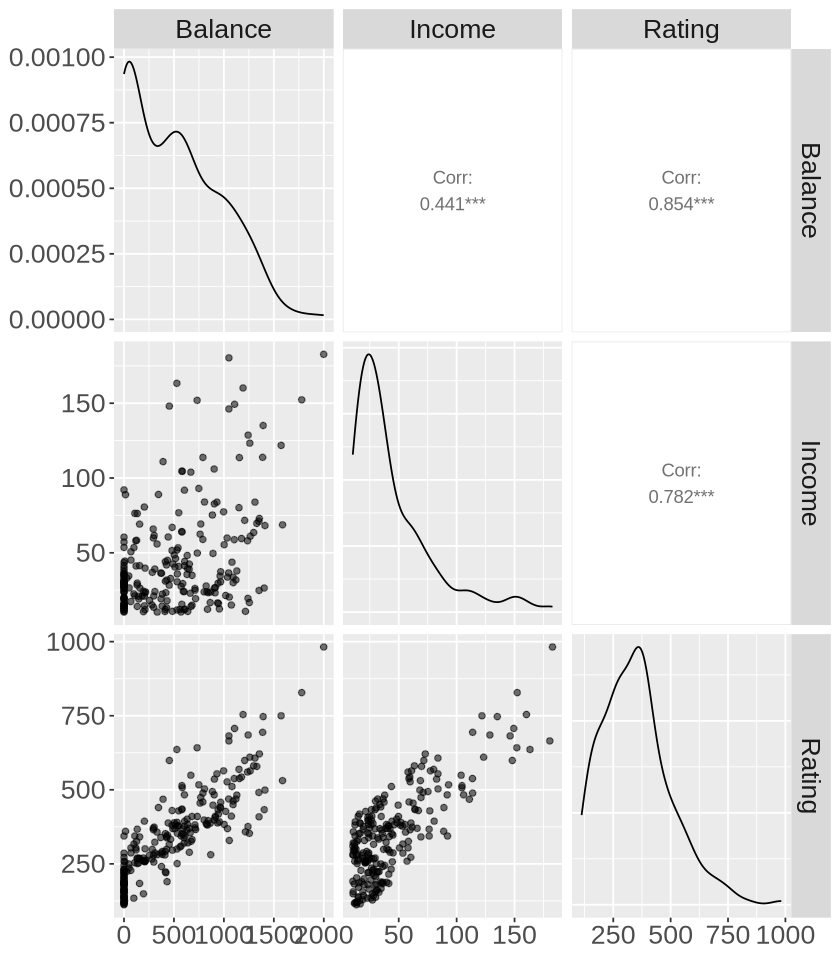

In [10]:
options(repr.plot.height = 8, repr.plot.width = 7)
 credit_pairplot <- credit_training |> 
     ggpairs(mapping = aes(alpha = 0.4)) +
     theme(text = element_text(size = 20))

# your code here
 # No Answer - remove if you provide an answer
credit_pairplot

In [11]:
library(digest)
stopifnot("type of ('ggmatrix' %in% c(class(credit_pairplot))) is not logical"= setequal(digest(paste(toString(class(('ggmatrix' %in% c(class(credit_pairplot))))), "19d5a")), "a4aac42f2ce4e5027c668c77c60cd78d"))
stopifnot("logical value of ('ggmatrix' %in% c(class(credit_pairplot))) is not correct"= setequal(digest(paste(toString(('ggmatrix' %in% c(class(credit_pairplot)))), "19d5a")), "08e38bf77f0f71ca45eeaa541d42c31a"))

print('Success!')

[1] "Success!"


**Question 1.4** Multiple Choice:
<br> {points: 1} 

Looking at the `ggpairs` plot above, which of the following statements is **incorrect**?

A. There is a strong positive relationship between the response variable (`Balance`) and the `Rating` predictor

B. There is a strong positive relationship between the two predictors (`Income` and `Rating`)

C. There is a strong positive relationship between the response variable (`Balance`) and the `Income` predictor

D. None of the above statements are incorrect

*Assign your answer to an object called `answer1.4`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [19]:
# your code here
answer1.4<-"C"# No Answer - remove if you provide an answer
answer1.4

[1] "C"

In [20]:
library(digest)
stopifnot("type of answer1.4 is not character"= setequal(digest(paste(toString(class(answer1.4)), "2470e")), "92083ff14963ea52805cb525e8b9a97b"))
stopifnot("length of answer1.4 is not correct"= setequal(digest(paste(toString(length(answer1.4)), "2470e")), "0c72f34e39b62bab8f303b80bc1e68ff"))
stopifnot("value of answer1.4 is not correct"= setequal(digest(paste(toString(tolower(answer1.4)), "2470e")), "6c5da10615814fa775e8ce0c963130fd"))
stopifnot("letters in string value of answer1.4 are correct but case is not correct"= setequal(digest(paste(toString(answer1.4), "2470e")), "b64109fc8b41777dbd3a68c99230ab9a"))

print('Success!')

[1] "Success!"


**Question 1.5**
<br> {points: 1}

Now that we have our training data, we will fit a linear regression model.

- Create and assign your linear regression model specification to an object called `lm_spec`.  
- Create a recipe for the model. Assign your answer to an object called `credit_recipe`.

In [27]:
set.seed(2020) #DO NOT REMOVE

lm_spec<-linear_reg()|>
set_engine("lm")|>
set_mode("regression")

credit_recipe<-recipe(Balance~Income+Rating, data=credit_training)

    # your code here
# No Answer - remove if you provide an answer
print(lm_spec)
print(credit_recipe)

Linear Regression Model Specification (regression)

Computational engine: lm 





── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



In [28]:
library(digest)
stopifnot("lm_spec should be a model specification"= setequal(digest(paste(toString('model_spec' %in% class(lm_spec)), "4359f")), "c3de4adb350c9e72231be36e3e1eb182"))
stopifnot("model specification in lm_spec is not correct"= setequal(digest(paste(toString(lm_spec$mode), "4359f")), "62b85f5ef268656caad854508d4abfda"))
stopifnot("computational engine in lm_spec is not correct"= setequal(digest(paste(toString(lm_spec$engine), "4359f")), "39f6e4d4d36e0daef96c9b118fe1d1c5"))

stopifnot("credit_recipe should be a recipe"= setequal(digest(paste(toString('recipe' %in% class(credit_recipe)), "435a0")), "a647787d013d8bcd1694e360b1e6fd2c"))
stopifnot("response variable of credit_recipe is not correct"= setequal(digest(paste(toString(sort(filter(credit_recipe$var_info, role == 'outcome')$variable)), "435a0")), "b64c7a642289dc1c8234eb9dafbc6829"))
stopifnot("predictor variable(s) of credit_recipe are not correct"= setequal(digest(paste(toString(sort(filter(credit_recipe$var_info, role == 'predictor')$variable)), "435a0")), "2c77215bbbe86725386f42bed206b92f"))
stopifnot("credit_recipe does not contain the correct data, might need to be standardized"= setequal(digest(paste(toString(round(sum(bake(prep(credit_recipe), credit_recipe$template) %>% select_if(is.numeric), na.rm = TRUE), 2)), "435a0")), "fcffff419aaf2314a613292ab7f9a70b"))

print('Success!')

[1] "Success!"


**Question 1.6**
<br> {points: 1}

Now that we have our model specification and recipe, let's put them together in a workflow, and fit our simple linear regression model. Assign the fit to an object called `credit_fit`. 

In [29]:
set.seed(2020) # DO NOT REMOVE

# your code here
# No Answer - remove if you provide an answer
credit_fit<- workflow() |>
       add_recipe(credit_recipe) |>
       add_model(lm_spec) |>
       fit(credit_training)
credit_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)       Income       Rating  
   -528.014       -7.583        3.937  


In [30]:
library(digest)
stopifnot("credit_fit should be a workflow"= setequal(digest(paste(toString('workflow' %in% class(credit_fit)), "da8fd")), "08b5402a06e4e7d505f86c790e04cdd5"))
stopifnot("computational engine used in credit_fit is not correct"= setequal(digest(paste(toString(credit_fit$fit$actions$model$spec$engine), "da8fd")), "eff86ec04cc914c8876e049edf0bc11a"))
stopifnot("model specification used in credit_fit is not correct"= setequal(digest(paste(toString(credit_fit$fit$actions$model$spec$mode), "da8fd")), "a009304440d323b364eb9bcfdbf5945f"))
stopifnot("credit_fit must be a trained workflow, make sure to call the fit() function"= setequal(digest(paste(toString(credit_fit$trained), "da8fd")), "08b5402a06e4e7d505f86c790e04cdd5"))
stopifnot("predictor variable(s) of credit_fit are not correct"= setequal(digest(paste(toString(sort(filter(credit_fit$pre$actions$recipe$recipe$var_info, role == 'predictor')$variable)), "da8fd")), "401a1c3a99cd85bff827fdbf95dd05bb"))
stopifnot("credit_fit does not contain the correct data"= setequal(digest(paste(toString(sort(vapply(credit_fit$pre$mold$predictors[, sapply(credit_fit$pre$mold$predictors, is.numeric)], function(col) if(!is.null(col)) round(sum(col), 2) else NA_real_, numeric(1)), na.last = NA)), "da8fd")), "73e8abdd4f024e52cb135781464de30a"))
stopifnot("did not fit credit_fit on the training dataset"= setequal(digest(paste(toString(nrow(credit_fit$pre$mold$outcomes)), "da8fd")), "97a0796a6babc345e0a5344b0295a6a8"))
stopifnot("for classification/regression models, weight function is not correct"= setequal(digest(paste(toString(quo_name(credit_fit$fit$actions$model$spec$args$weight_func)), "da8fd")), "308a615b6fa74f4c90a75b0de572e617"))
stopifnot("for classification/regression models, response variable of credit_fit is not correct"= setequal(digest(paste(toString(sort(filter(credit_fit$pre$actions$recipe$recipe$var_info, role == 'outcome')$variable)), "da8fd")), "9a592cadad15dc40ffa84567eb830818"))
stopifnot("for KNN models, number of neighbours is not correct"= setequal(digest(paste(toString(quo_name(credit_fit$fit$actions$model$spec$args$neighbors)), "da8fd")), "308a615b6fa74f4c90a75b0de572e617"))
stopifnot("for clustering models, the clustering is not correct"= setequal(digest(paste(toString(credit_fit$fit$fit$fit$cluster), "da8fd")), "e59bb1522a273640eccd2ef95be05fdd"))
stopifnot("for clustering models, the total within-cluster sum-of-squared distances is not correct"= setequal(digest(paste(toString(if (!is.null(credit_fit$fit$fit$fit$tot.withinss)) round(credit_fit$fit$fit$fit$tot.withinss, 2) else NULL), "da8fd")), "e59bb1522a273640eccd2ef95be05fdd"))

print('Success!')

[1] "Success!"


**Question 1.7** Multiple Choice:
<br> {points: 1}

Looking at the slopes/coefficients above from each of the predictors, which of the following mathematical equations is correct for your prediction model?

A. $credit\: card \: balance = -528.014 -7.583*income  + 3.937*credit\: card\: rating$

B. $credit\: card \: balance = -528.014 + 3.937*income  -7.583*credit\: card\: rating$

C. $credit\: card \: balance = 528.014 -7.583*income  - 3.937*credit\: card\: rating$

D. $credit\: card \: balance = 528.014 - 3.937*income  + 7.583*credit\: card\: rating$

*Assign your answer to an object called `answer1.7`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [40]:
# your code here
answer1.7<-"A"# No Answer - remove if you provide an answer
answer1.7

[1] "A"

In [41]:
library(digest)
stopifnot("type of answer1.7 is not character"= setequal(digest(paste(toString(class(answer1.7)), "c7d33")), "5d0f5ba005fb57b8f62027a2e6e2dcdd"))
stopifnot("length of answer1.7 is not correct"= setequal(digest(paste(toString(length(answer1.7)), "c7d33")), "350efce462fcd4f546cb60b9b91c0ca9"))
stopifnot("value of answer1.7 is not correct"= setequal(digest(paste(toString(tolower(answer1.7)), "c7d33")), "ebd9146c0435d6b190731b9392b38463"))
stopifnot("letters in string value of answer1.7 are correct but case is not correct"= setequal(digest(paste(toString(answer1.7), "c7d33")), "adc580d20efbbb241cebd46879fdcefd"))

print('Success!')

[1] "Success!"


**Question 1.8**
<br> {points: 1}

Calculate the $RMSE$ to assess goodness of fit on `credit_fit` (remember this is how well it predicts on the training data used to fit the model). Return a single numerical value named `lm_rmse`.

In [43]:
set.seed(2020) # DO NOT REMOVE

lm_rmse<- credit_fit |>
         predict(new_data= credit_training) |>
        bind_cols(credit_training) |>
         metrics(truth = Balance, estimate = .pred) |>
        filter(.metric == "rmse") |>
        select(.estimate) |>
        pull()

# your code here
 # No Answer - remove if you provide an answer
lm_rmse

[1] 167.3179

In [44]:
library(digest)
stopifnot("type of round(lm_rmse, 2) is not numeric"= setequal(digest(paste(toString(class(round(lm_rmse, 2))), "90585")), "6a9a39be28e580cc8d4c18896f797996"))
stopifnot("value of round(lm_rmse, 2) is not correct (rounded to 2 decimal places)"= setequal(digest(paste(toString(round(round(lm_rmse, 2), 2)), "90585")), "6fa56a60d830b3be9852ded837c36390"))
stopifnot("length of round(lm_rmse, 2) is not correct"= setequal(digest(paste(toString(length(round(lm_rmse, 2))), "90585")), "4ed611d7e1139df7d957b9c733499f31"))
stopifnot("values of round(lm_rmse, 2) are not correct"= setequal(digest(paste(toString(sort(round(round(lm_rmse, 2), 2))), "90585")), "6fa56a60d830b3be9852ded837c36390"))

print('Success!')

[1] "Success!"


**Question 1.9**
<br> {points: 1}

Calculate $RMSPE$ using the test data. Return a single numerical value named `lm_rmspe`.

In [66]:
set.seed(2020) # DO NOT REMOVE

lm_rmspe_intermediate<- credit_fit |>
         predict(new_data= credit_testing) |>
        bind_cols(credit_testing) |>
         metrics(truth = Balance, estimate = .pred) 
lm_rmspe<-lm_rmspe_intermediate|>
filter(.metric=="rmse") |>
pull(.estimate)

round(lm_rmspe,2)

# your code here
# No Answer - remove if you provide an answer
lm_rmspe

[1] 154.84

[1] 154.839

In [67]:
library(digest)
stopifnot("type of round(lm_rmspe, 2) is not numeric"= setequal(digest(paste(toString(class(round(lm_rmspe, 2))), "d4d4e")), "77487a178cef06539698a33a47356441"))
stopifnot("value of round(lm_rmspe, 2) is not correct (rounded to 2 decimal places)"= setequal(digest(paste(toString(round(round(lm_rmspe, 2), 2)), "d4d4e")), "1f76be0333f694c6626e4a04cb355366"))
stopifnot("length of round(lm_rmspe, 2) is not correct"= setequal(digest(paste(toString(length(round(lm_rmspe, 2))), "d4d4e")), "56dae57dc27a17e694234b2c468c7283"))
stopifnot("values of round(lm_rmspe, 2) are not correct"= setequal(digest(paste(toString(sort(round(round(lm_rmspe, 2), 2))), "d4d4e")), "1f76be0333f694c6626e4a04cb355366"))

print('Success!')

[1] "Success!"


**Question 1.9.1**
<br> {points: 3}

Redo this analysis using $k$-nn regression instead of linear regression. Use `set.seed(2000)` at the beginning of this code cell to make it reproducible. Use the same predictors and train - test data splits as you used for linear regression, and use 5-fold cross validation to **choose $k$ from the range 1-10**. Remember to scale and shift your predictors on your training data, and to apply that same standardization to your test data! 
Assign a single numeric value for $RMSPE$ for your k-nn model as your answer, and name it `knn_rmspe`. 

In [ ]:
set.seed(2000) # DO NOT REMOVE

# your code here
# No Answer - remove if you provide an answer
knn_rmspe

**Question 1.9.2** 
<br> {points: 3}

Discuss which model, linear regression versus $k$-nn regression, gives better predictions and why you think that might be happening.

DOUBLE CLICK TO EDIT **THIS CELL** AND REPLACE THIS TEXT WITH YOUR ANSWER.

## 2. Ames Housing Prices

<img src="https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif" width = "600"/>

Source: https://media.giphy.com/media/xUPGGuzpmG3jfeYWIg/giphy.gif

If we take a look at the Business Insider report [What do millenials want in a home?](https://www.businessinsider.com/what-do-millennials-want-in-a-home-2017-2), we can see that millenials like newer houses that have their own defined spaces. Today we are going to be looking at housing data to understand how the sale price of a house is determined. Finding highly detailed housing data with the final sale prices is very hard, however researchers from Truman State Univeristy have studied and made available a dataset containing multiple variables for the city of Ames, Iowa. The data set describes the sale of individual residential property in Ames, Iowa
from 2006 to 2010. You can read more about the data set [here](http://jse.amstat.org/v19n3/decock.pdf). Today we will be looking at 5 different variables to predict the sale price of a house. These variables are: 

- Lot Area: `lot_area`
- Year Built: `year_built`
- Basement Square Footage: `bsmt_sf`
- First Floor Square Footage: `first_sf`
- Second Floor Square Footage: `second_sf`

First, load the data with the script given below. 

In [ ]:
# run this cell

ames_data <- read_csv('data/ames.csv', col_types = cols()) |>
    select(lot_area = Lot.Area, 
           year_built = Year.Built, 
           bsmt_sf = Total.Bsmt.SF, 
           first_sf = `X1st.Flr.SF`, 
           second_sf = `X2nd.Flr.SF`, 
           sale_price = SalePrice) |>
    filter(!is.na(bsmt_sf))

ames_data

**Question 2.1**
<br> {points: 3}

Split the data into a train dataset and a test dataset, based on a 70%-30% train-test split. Use `set.seed(2019)`. Remember that we want to predict the `sale_price` based on all of the other variables. 

Assign the objects to `ames_split`, `ames_training`, and `ames_testing`, respectively. 

*Use 2019 as your seed for the split.*

In [ ]:
set.seed(2019) # DO NOT CHANGE!
# your code here
fail() # No Answer - remove if you provide an answer

In [ ]:
library(digest)
stopifnot("type of exists('ames_split') is not logical"= setequal(digest(paste(toString(class(exists('ames_split'))), "230f3")), "9bfe53b14af9936e829981faefd1ec9c"))
stopifnot("logical value of exists('ames_split') is not correct"= setequal(digest(paste(toString(exists('ames_split')), "230f3")), "dfb66d669e47e49afa08a37014151e74"))

stopifnot("type of exists('ames_training') is not logical"= setequal(digest(paste(toString(class(exists('ames_training'))), "230f4")), "c882555a076c4abf44c38637add9ddcd"))
stopifnot("logical value of exists('ames_training') is not correct"= setequal(digest(paste(toString(exists('ames_training')), "230f4")), "5b023101d4defc826a7de694302ffea4"))

stopifnot("type of exists('ames_testing') is not logical"= setequal(digest(paste(toString(class(exists('ames_testing'))), "230f5")), "40374f0ff3e682bc183a4c1fe1c24f99"))
stopifnot("logical value of exists('ames_testing') is not correct"= setequal(digest(paste(toString(exists('ames_testing')), "230f5")), "0bd00aba3fcaac4eebd0f42423851903"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.2**
<br> {points: 3}

Let's start by exploring the training data. Use the `ggpairs()` function from the GGally package to explore the relationships between the different variables. 

Assign your plot object to a variable named `answer2.2`. 

In [ ]:
set.seed(2020) # DO NOT REMOVE

# your code here
fail() # No Answer - remove if you provide an answer
answer2.2

In [ ]:
library(digest)
stopifnot("type of exists('answer2.2') is not logical"= setequal(digest(paste(toString(class(exists('answer2.2'))), "33164")), "7f6a081159192ad6c81340cd01e689fd"))
stopifnot("logical value of exists('answer2.2') is not correct"= setequal(digest(paste(toString(exists('answer2.2')), "33164")), "a1a12956e60caacb314157d83642106f"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.3** Multiple Choice:
<br> {points: 1}

Now that we have seen all the relationships between the variables, based solely on the scatterplots displayed above, which of the following variables would *not* be a  strong predictor for `sale_price`?

A. `bsmt_sf`

B. `year_built`

C. `first_sf`

D. `lot_area`

E. `second_sf`

F. It isn't clear from these plots

*Assign your answer to an object called `answer2.3`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer
answer2.3

In [ ]:
library(digest)
stopifnot("type of exists('answer2.3') is not logical"= setequal(digest(paste(toString(class(exists('answer2.3'))), "6c22")), "aaf085d3f505a408e74d60bece2dbe20"))
stopifnot("logical value of exists('answer2.3') is not correct"= setequal(digest(paste(toString(exists('answer2.3')), "6c22")), "f6fba0ece7a6dd9c23e333aef11bc0d3"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.4 - Linear Regression**
<br> {points: 3}

Fit a linear regression model using `tidymodels` with `ames_training` using **all** the variables in the data set. 
- create a model specification called `lm_spec`
- create a recipe called `ames_recipe`
- create a workflow with your model spec and recipe, and then create the model fit and name it `ames_fit`

In [ ]:
set.seed(2020) # DO NOT REMOVE

# your code here
fail() # No Answer - remove if you provide an answer
ames_fit

In [ ]:
library(digest)
stopifnot("type of exists('lm_spec') is not logical"= setequal(digest(paste(toString(class(exists('lm_spec'))), "73522")), "49c7807dc3a214063b40fddf0333551f"))
stopifnot("logical value of exists('lm_spec') is not correct"= setequal(digest(paste(toString(exists('lm_spec')), "73522")), "d004d6c80a083270385cb8c0e77149e5"))

stopifnot("type of exists('ames_recipe') is not logical"= setequal(digest(paste(toString(class(exists('ames_recipe'))), "73523")), "6bdad682f3eaad44db008153c640bb15"))
stopifnot("logical value of exists('ames_recipe') is not correct"= setequal(digest(paste(toString(exists('ames_recipe')), "73523")), "5372abab632d76e476569b114029933c"))

stopifnot("type of exists('ames_fit') is not logical"= setequal(digest(paste(toString(class(exists('ames_fit'))), "73524")), "29d905c7132e32e05293edf27b0725fe"))
stopifnot("logical value of exists('ames_fit') is not correct"= setequal(digest(paste(toString(exists('ames_fit')), "73524")), "2a3d3e68ef4a8292c382d33d560f8c34"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.5** True or False:
<br> {points: 1}

Aside from the intercept, all the variables have a positive relationship with the `sale_price`. This can be interpreted as the value of the variables decrease, the prices of the houses increase. 

*Assign your answer to an object called `answer2.5`. Make sure your answer is in lowercase letters and is surrounded by quotation marks (e.g. `"true"` or `"false"`).*

In [ ]:
# run this cell
ames_fit$fit$fit$fit$coefficients

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer
answer2.5

In [ ]:
library(digest)
stopifnot("type of exists('answer2.5') is not logical"= setequal(digest(paste(toString(class(exists('answer2.5'))), "2c2b7")), "311acaef9c6b078459c07aa3c5e924a7"))
stopifnot("logical value of exists('answer2.5') is not correct"= setequal(digest(paste(toString(exists('answer2.5')), "2c2b7")), "bc92b54ba4e255635ba60ec9ad18fdd1"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.6**
<br> {points: 3}

Looking at the coefficients and intercept produced from the cell block above, write down the equation for the linear model.

Make sure to use correct math typesetting syntax (surround your answer with dollar signs, e.g. `$0.5 * a$`)

DOUBLE CLICK TO EDIT **THIS CELL** AND REPLACE THIS TEXT WITH YOUR ANSWER.


**Question 2.7** Multiple Choice:
<br> {points: 1}

Why can we not easily visualize the model above as a line or a plane in a single plot?

A. This is not true, we can actually easily visualize the model

B. The intercept is much larger (6 digits) than the coefficients (single/double digits)

C. There are more than 2 predictors

D. None of the above

*Assign your answer to an object called `answer2.7`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer
answer2.7

In [ ]:
library(digest)
stopifnot("type of exists('answer2.7') is not logical"= setequal(digest(paste(toString(class(exists('answer2.7'))), "cb6da")), "7f3c950e77b17682f55f873011f770fd"))
stopifnot("logical value of exists('answer2.7') is not correct"= setequal(digest(paste(toString(exists('answer2.7')), "cb6da")), "5bce8d430bab7188a2a77689dd184827"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.8**
<br> {points: 3}

We need to evaluate how well our model is doing. For this question, calculate the $RMSPE$ (a single numerical value) of the linear regression model using the test data set and assign it to an object named `ames_rmspe`.

In [ ]:
set.seed(2020) # DO NOT REMOVE

# your code here
fail() # No Answer - remove if you provide an answer
ames_rmspe

In [ ]:
library(digest)
stopifnot("type of exists('ames_rmspe') is not logical"= setequal(digest(paste(toString(class(exists('ames_rmspe'))), "bfd0")), "965c939f8d7144c3c043b0e8ff1ff3a9"))
stopifnot("logical value of exists('ames_rmspe') is not correct"= setequal(digest(paste(toString(exists('ames_rmspe')), "bfd0")), "5b75a9b11a7a7b727f4a1c3fd4b1e3e8"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

**Question 2.9** Multiple Choice:
<br> {points: 1}

Which of the following statements is **incorrect**?

A. $RMSE$ is a measure of goodness of fit 

B. $RMSE$ measures how well the model predicts on data it was trained with 

C. $RMSPE$ measures how well the model predicts on data it was not trained with 

D. $RMSPE$ measures how well the model predicts on data it was trained with

*Assign your answer to an object called `answer2.9`. Make sure your answer is an uppercase letter and is surrounded by quotation marks (e.g. `"F"`).*

In [ ]:
# your code here
fail() # No Answer - remove if you provide an answer
answer2.9

In [ ]:
library(digest)
stopifnot("type of exists('answer2.9') is not logical"= setequal(digest(paste(toString(class(exists('answer2.9'))), "1bd43")), "b67dc07817e26a91562ec3a728c627fd"))
stopifnot("logical value of exists('answer2.9') is not correct"= setequal(digest(paste(toString(exists('answer2.9')), "1bd43")), "21a9dc1612eeb7a0abfb464fa5f9b30b"))

# The rest of the tests are intentionally hidden so that you can practice deciding 
# when you have found the correct answer. 
print('Success!')

In [ ]:
source("cleanup.R")